# Introduction
Hey, I'm Miika. I'm a Data Science Msc student at the University of Helsinki. I'm currently firmly transitioning into working life, and this is my attempt to have a clear and systematic look at whether or not I oughta 

    1) Rent an apartment
    2) Take a mortgage

For this analysis to be useful, I need to disclose some key numbers. As a software engineer by trade, I want anyone in, what should approximate, a situation similar to mine (young professional with some wealth in ETF's or equivalent, in Helsinki who wants to live close to the center of the city) to be able to plug in some of their numbers and understand my argument from their perspective, considering only the financials.

**Note that this should be viewed as my OPINION of whether or not it's worth for you, using assumptions that I've set. The program does not claim to approximate the actual outcome of your purchase.**

# Numbers

Alright, let's start plugging in some basic stuff. We'll want to consider a few things:

    1) If you have investments, we need to approximate the annual return. For this, if your investments resides in the finnish markets, I pray for you. For American ETF's or stocks, I'll use the standard 7% inflation accounted for number. For simplicity, I'm assuming that you will never sell, or at least pay tax on your stocks that you're trading.

    2) We need to consider the growth rate for the apartment itself: https://kaupunkitieto.hel.fi/fi/asuminen/asuntomarkkinat/asuntojen-hinnat. This source defines the city as a group of 5 kalleusalue. We're supposing that we're interested in kalleusalue 1 and 2 alone. In 14 years, they've risen about 36%. This means that average yearly value added is given by 100*1.0225^14 = ~136, so 2.25%.
       
       This is NOT inflation accounted as far as I understand, so this screams a bad deal thus far


In [1]:
# Expected profit
APPROXIMATE_ROI_ON_STOCKS = 0.07
INFLATION = 0.02
APPROXIMATE_VALUE_GROWTH_APARTMENT = 0.0225 - INFLATION


    3) We're interested in the total costs of renting an apartment vs buying one. I'm using the logic provided by POP bank here: https://www.poppankki.fi/blogi/kannattaako-asua-vuokralla-vai-ostaa-asunto

In [2]:
# Rental costs
RENT = 1050
RENT_ANNUAL_INCREASE = 0.02

# Costs of ownership
APARTMENT_COST = 300000
YHTIOVASTIKE = 300
EURIBOR = 0.02
MARGIN = 0.005
LOAN_DURATION_YEARS = 25
DOWN_PAYMENT_PERCENTAGE = 0.05 # for first time home buyers

# Common
UTILITIES = 100


    4) We're also interested in the tax outlook for the given choices

In [3]:
CAPITAL_GAINS_TAX = 0.34

# Running the numbers


# Monthly payment
Simple assumption: we look at outcome after the loan has been paid for. We will use the annuity formula

$A= P \frac{\frac{R}{12}(1+\frac{R}{12})^n}{(1+\frac{R}{12})^n + 1}$ 

Here
 - A is the monthly payment 
 - P is the principal
 - R is the fixed interest rate
 - n is the duration in months

In [4]:
principal = round(APARTMENT_COST - (APARTMENT_COST * DOWN_PAYMENT_PERCENTAGE))
interest = (EURIBOR + MARGIN)/12
duration = LOAN_DURATION_YEARS*12

monthly_payment = int(principal * ( (interest*((1+interest)**duration))/((1+interest)**duration - 1)))
total_cost = UTILITIES + YHTIOVASTIKE + monthly_payment

print(f"When principal is {principal:.0f}€ with interest of {interest*12:.3f}%, for {duration} months:\n Monthly payment is {monthly_payment:.0f}€ \n Total cost of living is {total_cost:.0f}€")

When principal is 285000€ with interest of 0.025%, for 300 months:
 Monthly payment is 1278€ 
 Total cost of living is 1678€


# Future value of investment strategy

Let's now compute the investment future value, supposing we invest this amount instead of paying it into the equity, deducting the rent we pay.

In [5]:
def future_value(initial_investment, monthly_contribution, annual_rate, years):
    r = annual_rate / 12  
    n = years * 12
    fv = (initial_investment * (1 + r) ** n) + (monthly_contribution * ((1 + r) ** n - 1) / r) * (1 + r)
    return round(fv, 2)

monthly_rent_deducted = total_cost - RENT

fv = future_value(0, monthly_rent_deducted, APPROXIMATE_ROI_ON_STOCKS, 25)
gross_profit = (fv - duration*total_cost)
net_profit = gross_profit*(1-CAPITAL_GAINS_TAX)


print(f"Suppose we invested the difference after 25 years: {fv:.0f}€ \n of which gross profit is {gross_profit:.0f}€\n of which net profit is {net_profit:.0f}€")


Suppose we invested the difference after 25 years: 511693€ 
 of which gross profit is 8293€
 of which net profit is 5473€


In most cases, it's really starting to look bleak for the mortgage option. If not, you've got a really good real, or really bad investing strategy going. Let's now look at the actual equity you expect to have with the apartment inflation adjusted supposing you're an owner at peak areas in Helsinki. 

In [6]:
equity_value_after_mortgage = future_value(APARTMENT_COST, 0, APPROXIMATE_VALUE_GROWTH_APARTMENT, 25)
print(f"Equity for mortgage after a time is {equity_value_after_mortgage:.0f}€")
print(f"The difference between the two strategies is {fv - equity_value_after_mortgage:.0f}€ before taxes")

Equity for mortgage after a time is 319346€
The difference between the two strategies is 192346€ before taxes


Note that we'd deduct some taxes from this, but generally speaking just living in your own apartment is not going to be worth it. We can look at a 50 year time horizon as well.

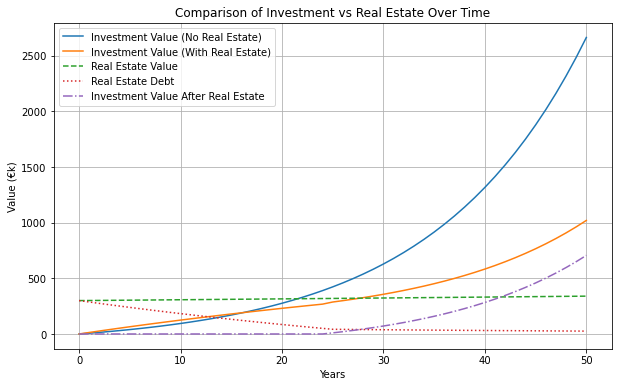

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def plot_investment_vs_real_estate(years, yearly_mortgage_payment, interest):
    time = np.arange(years + 1)
    investment_value = np.zeros(years + 1)
    investment_value_post_real_estate = np.zeros(years + 1)
    real_estate_value = np.zeros(years + 1)
    real_estate_debt = np.zeros(years + 1)

    real_estate_value[0] = APARTMENT_COST
    real_estate_debt[0] = APARTMENT_COST
    investment_value[0] = 0
    investment_value_post_real_estate[0] = 0

    rent = RENT

    for year in range(1, years + 1):
        rent *= (1+RENT_ANNUAL_INCREASE)
        real_estate_value[year] = real_estate_value[year - 1] * (1 + APPROXIMATE_VALUE_GROWTH_APARTMENT)

        if year <= LOAN_DURATION_YEARS:
            real_estate_debt[year] = (real_estate_debt[year - 1] * (1 + interest) - yearly_mortgage_payment) / (1 + INFLATION)
        else:
            real_estate_debt[year] = real_estate_debt[year - 1] / (1 + INFLATION)

        investment_value[year] = (investment_value[year - 1] + yearly_mortgage_payment - rent) * (1 + APPROXIMATE_ROI_ON_STOCKS)

        if year > LOAN_DURATION_YEARS:
            investment_value_post_real_estate[year] = (investment_value_post_real_estate[year - 1] + yearly_mortgage_payment + rent) * (1 + APPROXIMATE_ROI_ON_STOCKS)
        elif year == LOAN_DURATION_YEARS:
            investment_value_post_real_estate[year] = (yearly_mortgage_payment + rent) * (1 + APPROXIMATE_ROI_ON_STOCKS)

    real_estate_debt /= 1000
    investment_value /= 1000
    real_estate_value /= 1000
    investment_value_post_real_estate /= 1000

    plt.figure(figsize=(10, 6))
    plt.plot(time, investment_value, label="Investment Value (No Real Estate)")
    plt.plot(time, real_estate_value - real_estate_debt + investment_value_post_real_estate, label="Investment Value (With Real Estate)")
    plt.plot(time, real_estate_value, label="Real Estate Value", linestyle="--")
    plt.plot(time, real_estate_debt, label="Real Estate Debt", linestyle=":")
    plt.plot(time, investment_value_post_real_estate, label="Investment Value After Real Estate", linestyle="-.")
    
    plt.xlabel("Years")
    plt.ylabel("Value (€k)")
    plt.legend()
    plt.title("Comparison of Investment vs Real Estate Over Time")
    plt.grid()
    plt.show()
    
    
plot_investment_vs_real_estate(50, monthly_rent_deducted*12, interest)



This plot does not even account for the opportunity cost of being bound to the apartment, or being in debt for that amount, which is going to be massive on it's own. It accounts for the fact that after paying out the loan, you will invest the money you save into investments, and that you're not paying for rent.